# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE

In [2]:
import vbranch as vb
from vbranch.utils.training_utils import get_data, bag_samples, get_data_iterator
from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.test_utils import baseline_classification, vbranch_classification
from vbranch.applications.fcn import SimpleFCNv1, SimpleFCNv2
from vbranch.applications.cnn import SimpleCNNSmall

In [3]:
SAVE = False
MODEL_ID = 1
ARCHITECTURE = 'fcn'
DATASET = 'mnist'
NUM_CLASSES = 10
NUM_FEATURES = 784
SAMPLES_PER_CLASS = 100
BAGGING_SAMPLES = 0.6

NUM_BRANCHES = 1
SHARED_FRAC = 0
BATCH_SIZE = 32
EPOCHS = 10
STEPS_PER_EPOCH = 100

## Data

In [4]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                                NUM_FEATURES, SAMPLES_PER_CLASS)
x_shape = (None,) + X_train.shape[1:]
y_shape = (None, NUM_CLASSES)

In [5]:
# Perform bagging
x_train_list, y_train_list = bag_samples(X_train, y_train, NUM_BRANCHES, 
                                         max_samples=BAGGING_SAMPLES)

## Train

### Build

In [6]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                                      NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/mnist-fcn_1


In [7]:
tf.reset_default_graph()

# batch_size = tf.placeholder('int64', name='batch_size')

# if NUM_BRANCHES == 1:
#     x = tf.placeholder('float32', x_shape, name='x')
#     y = tf.placeholder('float32', y_shape, name='y')

#     dataset = tf.data.Dataset.from_tensor_slices((x,y)).\
#         batch(batch_size).repeat().\
#         shuffle(buffer_size=4*BATCH_SIZE)

#     iterators = dataset.make_initializable_iterator()
#     inputs, labels_one_hot = iterators.get_next('input')
# else:
#     x_list = []
#     y_list = []
#     iterators = []
#     inputs = []
#     labels_one_hot = []

#     for i in range(NUM_BRANCHES):
#         x = tf.placeholder('float32', x_shape, name='vb{:d}_x'.format(i+1))
#         y = tf.placeholder('float32', y_shape, name='vb{:d}_y'.format(i+1))

#         iter_ = tf.data.Dataset.from_tensor_slices((x,y)).\
#             repeat().batch(batch_size).shuffle(buffer_size=4*BATCH_SIZE).\
#             make_initializable_iterator()
#         input_, labels_one_hot_ = iter_.get_next('input')
        
#         x_list.append(x)
#         y_list.append(y)
#         iterators.append(iter_)
#         inputs.append(input_)
#         labels_one_hot.append(labels_one_hot_)

inputs, labels_one_hot, iterators = get_data_iterator(x_shape, y_shape, batch_size=BATCH_SIZE, 
                                                      n=NUM_BRANCHES, share_xy=BAGGING_SAMPLES == 1)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
def build_model(architecture,inputs,labels, num_classes,num_branches,model_id, shared_frac):
    if num_branches > 1 and isinstance(inputs, tf.Tensor):
        inputs = [inputs] * num_branches
        
    name = 'model_' + str(model_id)
    
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        if architecture == 'fcn':
            model = SimpleFCNv1(inputs, num_classes, name=name, shared_frac=shared_frac)
        elif architecture == 'cnn':
            model = SimpleCNNSmall(inputs, num_classes, name=name, shared_frac=shared_frac)
        else:
            raise ValueError('invalid model')
            
        if type(labels) is list:
            labels_list = labels
        else:
            labels_list = [labels] * num_branches
            
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        model.compile(optimizer, 'softmax_cross_entropy_with_logits',
                        labels_one_hot=labels_list)

    return model

In [9]:
model = build_model(ARCHITECTURE, inputs, labels_one_hot, NUM_CLASSES,
                    NUM_BRANCHES, MODEL_ID, SHARED_FRAC)
model.summary()

Instructions for updating:
Use tf.cast instead.
i  Layer name                Output shape  Parameters       Num param  Inbound  
--------------------------------------------------------------------------------
   Input                     [None,784]                                         
--------------------------------------------------------------------------------
0  fc1 (Dense)               [None,512]    [784,512] [512]  401920     input:0  
--------------------------------------------------------------------------------
1  bn1 (BatchNormalization)  [None,512]    [512] [512]      1024       fc1      
--------------------------------------------------------------------------------
2  relu1 (Activation)        [None,512]                     0          bn1      
--------------------------------------------------------------------------------
3  output (Dense)            [None,10]     [512,10] [10]    5130       relu1    
-------------------------------------------------------------

In [10]:
print(model.output)

Tensor("model_1/output/output:0", shape=(?, 10), dtype=float32)


In [11]:
# Build copy of model for testing
x_place = tf.placeholder('float32', x_shape, name='x_test')
y_place = tf.placeholder('float32', y_shape, name='y_test')

model_copy = build_model(ARCHITECTURE, x_place, y_place, 
                         NUM_CLASSES, NUM_BRANCHES, MODEL_ID, SHARED_FRAC)

In [12]:
# tf.global_variables()
# tf.get_default_graph().get_operations()

In [13]:
print(model_copy.output)

Tensor("model_1_1/output/output:0", shape=(?, 10), dtype=float32)


### Fit

In [14]:
if NUM_BRANCHES == 1:
    history = model.fit(iterators, X_train, y_train, EPOCHS, STEPS_PER_EPOCH,
                        BATCH_SIZE, validation=(X_test, y_test), test_model=model_copy,
                        save_model_path=model_path)
else:
    data_dict = {}

    for i in range(NUM_BRANCHES):
        data_dict['vb{}_x:0'.format(i+1)] = x_train_list[i]
        data_dict['vb{}_y:0'.format(i+1)] = y_train_list[i]

    history = model.fit_data(iterators, EPOCHS, STEPS_PER_EPOCH, BATCH_SIZE, 
                             data_dict=data_dict, 
                             val_dict={x_place: X_test, y_place: y_test}, 
                             test_model=model_copy, save_model_path=model_path)

Epoch 1/10
 - 1s - train_loss: 0.4849 - train_acc: 2.7250 - val_loss: 0.3032 - val_acc: 908.7000
Epoch 2/10
 - 1s - train_loss: 0.2276 - train_acc: 3.0090 - val_loss: 0.2452 - val_acc: 925.1000
Epoch 3/10
 - 1s - train_loss: 0.1642 - train_acc: 3.0620 - val_loss: 0.2123 - val_acc: 935.8000
Epoch 4/10
 - 1s - train_loss: 0.1122 - train_acc: 3.1080 - val_loss: 0.2100 - val_acc: 936.3000
Epoch 5/10
 - 1s - train_loss: 0.0823 - train_acc: 3.1520 - val_loss: 0.1942 - val_acc: 941.1000
Epoch 6/10
 - 1s - train_loss: 0.0750 - train_acc: 3.1340 - val_loss: 0.1919 - val_acc: 943.1000
Epoch 7/10
 - 1s - train_loss: 0.0509 - train_acc: 3.1670 - val_loss: 0.1962 - val_acc: 940.3000
Epoch 8/10
 - 1s - train_loss: 0.0373 - train_acc: 3.1780 - val_loss: 0.1809 - val_acc: 944.2000
Epoch 9/10
 - 1s - train_loss: 0.0280 - train_acc: 3.1900 - val_loss: 0.1776 - val_acc: 945.2000
Epoch 10/10
 - 1s - train_loss: 0.0311 - train_acc: 3.1780 - val_loss: 0.1998 - val_acc: 939.3000


## Evaluation

### Baseline

In [7]:
assert NUM_BRANCHES == 1

model_id_list = [1]
baseline_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, model_id)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        acc = baseline_classification(sess, X_test, y_test, 
                                      model_name='model_'+str(model_id)+'_1')
        print('Model {} acc:'.format(model_id), acc)
        baseline_acc_list.append(acc)
        
print('Mean acc:', np.mean(baseline_acc_list), ', std:', np.std(baseline_acc_list))

INFO:tensorflow:Restoring parameters from models/mnist-fcn_1/ckpt
Model 1 acc: 0.9459
Mean acc: 0.9459 , std: 0.0


### Ensemble

In [ ]:
test_outputs = []
test_losses = []
test_accs = []

num_models = 4
graphs = [tf.Graph() for _ in range(5)]
sessions = [tf.Session(graph=g) for g in graphs]

for i in np.random.choice(5, num_models, replace=False):
    with graphs[i].as_default():
        model_path = 'models/mnist-{}_{}'.format(architecture, i + 1)
        meta_path = os.path.join(model_path, 'ckpt.meta')
        ckpt = tf.train.get_checkpoint_state(model_path)
        
        imported_graph = tf.train.import_meta_graph(meta_path)
        imported_graph.restore(sessions[i], ckpt.model_checkpoint_path)
                
        sessions[i].run('test_init_op', feed_dict={'batch_size:0': len(X_test)})
        
        output, loss, acc = sessions[i].run(['model_%d'%(i+1)+'/'+'output:0', 
                                             'loss:0', 'acc:0'])
        test_outputs.append(output)
        test_losses.append(loss)
        test_accs.append(acc)

### Virtual Branching

In [6]:
model_id_list = [1]
vbranch_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                            NUM_BRANCHES, SHARED_FRAC, model_id)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        acc, branch_acc = vbranch_classification(sess, X_test, y_test, 
                                     model_name='model_'+str(model_id)+'_1', 
                                     num_classes=NUM_CLASSES, 
                                     n_branches=NUM_BRANCHES)
        print('Model {} acc:'.format(model_id), acc, branch_acc)
        vbranch_acc_list.append(acc)
        
print('Mean acc:', np.mean(vbranch_acc_list), ', std:', np.std(vbranch_acc_list))

INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn-B2-S0.00_1/ckpt
Model 1 acc: 0.9581 [0.953, 0.9516]
Mean acc: 0.9581 , std: 0.0


### Feature Visualization

In [17]:
def get_tsne(features):
    start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(features)

    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))
    return tsne_results

In [8]:
X_sample, y_sample = bag_samples(X_train, y_train, 1, max_samples=250)
print(X_sample.shape, y_sample.shape)

(250, 784) (250, 10)


In [9]:
tf.reset_default_graph()
model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
model_path = os.path.join('models', model_name)

with TFSessionGrow() as sess:
    restore_sess(sess, model_path)
    baseline_features = sess.run('model_{}_1/output/output:0'.format(MODEL_ID), 
                                 feed_dict={'x_test:0':X_sample})

INFO:tensorflow:Restoring parameters from models/mnist-fcn_1/ckpt


In [13]:
tf.reset_default_graph()
model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                            NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
    
with TFSessionGrow() as sess:
    restore_sess(sess, model_path)
    
    outputs = []
    for i in range(NUM_BRANCHES):
        name = os.path.join('model_{}_1/output/vb{}/output:0'.format(MODEL_ID, i+1))
        outputs.append(name)
        
    vbranch_features = sess.run(outputs, feed_dict={'x_test:0':X_sample})
    mean_vbranch_features = np.mean(vbranch_features, axis=0)

INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn-B2-S0.00_1/ckpt


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.002s...
[t-SNE] Computed neighbors for 250 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 7.259715
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.512409
[t-SNE] KL divergence after 300 iterations: 0.504960
t-SNE done! Time elapsed: 0.3521549701690674 seconds
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.000s...
[t-SNE] Computed neighbors for 250 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 7.740937
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.471642
[t-SNE] KL divergence after 300 iterations: 0.570972
t-SNE done! Time elapsed: 0.3209238052368164 seconds


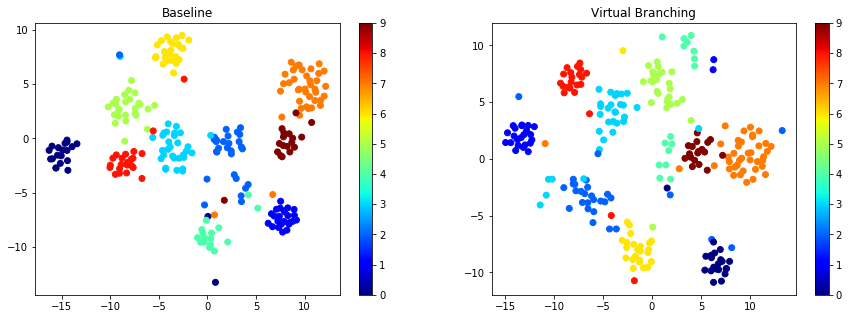

In [22]:
baseline_tsne = get_tsne(baseline_features)
vbranch_tsne = get_tsne(mean_vbranch_features)
sample_labels = np.argmax(y_sample, axis=-1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.scatter(baseline_tsne[:,0], baseline_tsne[:,1], c=sample_labels, cmap=plt.cm.jet)
plt.colorbar()
plt.title('Baseline')

plt.subplot(1, 2, 2)
plt.scatter(vbranch_tsne[:,0], vbranch_tsne[:,1], c=sample_labels, cmap=plt.cm.jet)
plt.colorbar()
plt.title('Virtual Branching')

plt.show()

### Correlation and Strength

In [5]:
from vbranch.utils.generic_utils import get_model_path, get_vb_model_path
from vbranch.utils.test_utils import compute_correlation_strength, compute_acc_from_logits

In [14]:
y_labels = np.argmax(y_test, axis=-1)

model_id_list = range(1, 9)
output_list = []
acc_list = []
pred_list = []

for model_id in model_id_list:
    tf.reset_default_graph()

    with tf.Session() as sess:
        model_path = get_model_path(DATASET, ARCHITECTURE, NUM_CLASSES, 
                                    SAMPLES_PER_CLASS, model_id)
        restore_sess(sess, model_path)
        output = sess.run('model_{}_1/output:0'.format(model_id),
            feed_dict={'x_test:0':X_test})

    output_list.append(output)
    acc_list.append(compute_acc_from_logits(output, y_test, NUM_CLASSES))
    pred_list.append(np.argmax(output, axis=1))
    
model_preds = np.array(pred_list).transpose(1,0)
baseline_corr, baseline_strength = compute_correlation_strength(model_preds, y_labels, 
                                                                NUM_CLASSES, 
                                                                len(model_id_list))

print('Mean correlation:', baseline_corr)
print('Strength:' , baseline_strength)

INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_5/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_6/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_7/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_8/ckpt
Mean correlation: 0.6910488884916635
Strength: 0.893675


In [15]:
shared_frac_list = [0, 0.25, 0.5, 0.75, 1]
shared_correlation_list = []
shared_strength_list = []

for shared in shared_frac_list:
    mean_correlation_list = []
    strength_list = []
    
    for model_id in range(1, 5):
        model_path = get_vb_model_path(DATASET, ARCHITECTURE, NUM_BRANCHES, shared, 
                                       NUM_CLASSES, SAMPLES_PER_CLASS, model_id)

        tensors = []
        for i in range(NUM_BRANCHES):
            if shared == 0:
                t = 'model_{}_1/output_vb{}:0'.format(model_id, i+1)
            else:
                t = 'model_{}_1/output_{}:0'.format(model_id, i+1)
            tensors.append(t)

        tf.reset_default_graph()

        with tf.Session() as sess:
            restore_sess(sess, model_path)
            feed_dict = feed_dict={'x_test:0': X_test, 'y_test:0': y_test}
            outputs, acc = sess.run([tensors, 'acc_ensemble_1:0'], feed_dict=feed_dict)
            
        preds = np.array([np.argmax(x, axis=1) for x in outputs]).transpose(1,0)
        mean_correlation, strength = compute_correlation_strength(preds, y_labels, NUM_CLASSES, NUM_BRANCHES)
        
        mean_correlation_list.append(mean_correlation)
        strength_list.append(strength)
        
    shared_correlation_list.append([np.mean(mean_correlation_list), np.std(mean_correlation_list)])
    shared_strength_list.append([np.mean(strength_list), np.std(strength_list)])

INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.00/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.50/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.50/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.50/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.50/model

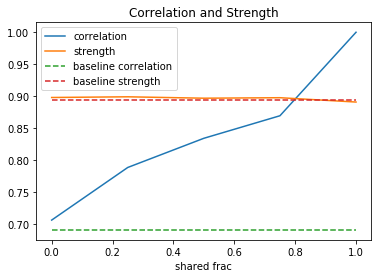

In [16]:
plt.plot(shared_frac_list, np.array(shared_correlation_list)[:, 0], label='correlation')
plt.plot(shared_frac_list, np.array(shared_strength_list)[:, 0], label='strength')

# Baseline
plt.plot(shared_frac_list, [baseline_corr]* len(shared_correlation_list), 
         label='baseline correlation', linestyle='--')
plt.plot(shared_frac_list, [baseline_strength]* len(shared_correlation_list), 
         label='baseline strength', linestyle='--')

plt.xlabel('shared frac')
plt.title('Correlation and Strength')
plt.legend()

plt.savefig('figs/correlation-strength.png')
plt.show()